In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers as layers

from mpl_toolkits.basemap import Basemap

import sklearn
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KernelDensity

from scipy.stats import gaussian_kde

from utils import *

## <center> Loading and preparing the data </center> 

In [2]:
# Importing data
input_data = np.load('data/data_200k.npy', allow_pickle=True)
label_data = np.load('data/labels_200k.npy')

In [3]:
# Converting to pandas dataframes
df_labels = pd.DataFrame(label_data)

# Adding col names and change some features
df_labels.columns = ['id', 'contry', 'region', 'groupA', 'era', 'flag', 'lat', 'long', 'source', 'age', 'coverage']
df_labels = df_labels.astype({'lat': float, 'long': float, 'age': int, 'coverage':float})

# Dropping columns that I don't need
labels = df_labels.drop(['groupA','flag' ,'source'], axis=1)

In [4]:
# Extending label-info
labels = labels.assign(chrom = input_data[:, 2])
labels = labels.assign(gen_pos = input_data[:, 1])
labels = labels.astype({'gen_pos': int})

In [7]:
# Creating train and test data
x_test = input_data[170000:, 0]
test_labels = labels.iloc[170000:]

x_train = input_data[:170000, 0]
train_labels = labels.iloc[:170000]

# Labels for location predictions
y_train_loc = train_labels.loc[:, 'lat':'long']
y_test_loc = test_labels.loc[:, 'lat':'long']

# Labels for age prediction
y_train_age = train_labels.loc[:, 'age':'age']
y_test_age = test_labels.loc[:, 'age':'age']

In [8]:
# Training data for both models
x_train_scaled, x_test_scaled = data_preprocessor(x_train, x_test)

In [9]:
# Labels for location scaled
y_train_loc_scaled, y_test_loc_scaled, label_scaler = label_preprocessor(y_train_loc, y_test_loc)

## <center> Training the location model </center>

In [11]:
# The location model architechture
input_img = layers.Input(shape=(128, 3))
x = layers.Conv1D(128, 3, name='conv_1', padding='same', activation='relu')(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D((2), name='max_pool_1')(x)

x = layers.Conv1D(128, 3, name='conv_2', padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D((2), name='max_pool_2')(x)


x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(2, activation='sigmoid')(x)

In [12]:
model = Model(input_img, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 3)]          0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 128, 128)          1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128)          512       
_________________________________________________________________
max_pool_1 (MaxPooling1D)    (None, 64, 128)           0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 64, 128)           49280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 128)           512       
_________________________________________________________________
max_pool_2 (MaxPooling1D)    (None, 32, 128)           0     

In [13]:
model.compile(optimizer=get_optimizer(), loss=tf_haversine, metrics=['accuracy'])

In [14]:
# Checkpoints and early stopping 
#checkpoint_path = "ex_1/cp_coords.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

#checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, verbose=1)
#early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
#callback = [checkpoint, early_stop]

In [15]:
# Fit the model
#history = model.fit(x_train_scaled, y_train_loc_scaled,
#                    epochs=200, batch_size=128,
#                    shuffle=True,
#                    validation_split=0.2,
#                    callbacks=callback)

In [16]:
#plot_loss(history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy'])

In [17]:
# Loading the best model saved
model_all = Model(input_img, x)
model_all.compile(optimizer=get_optimizer(), loss=tf_haversine, metrics=['accuracy'])

model_all.load_weights("ex_2/cp_coords.ckpt")

# Re-evaluate the model
loss,acc = model_all.evaluate(x_test_scaled,  y_test_loc_scaled, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

30000/1 - 21s - loss: 18.3778 - accuracy: 0.8510
Restored model, accuracy: 85.10%


In [18]:
# Predicting the locations
loc_preds = model_all.predict(x_test_scaled)
# Transforming scaled locations back to original space
loc_preds_inv = label_scaler.inverse_transform(loc_preds)

In [19]:
# proper way of assigning to df without warnings
test_labels = test_labels.assign(lat_pred = loc_preds_inv[:, 0])
test_labels = test_labels.assign(long_pred = loc_preds_inv[:, 1])

## <center> Training the age model </center>

In [21]:
# Returns arrays
y_train_age_arr = y_train_age.values
y_test_age_arr = y_test_age.values

In [22]:
categoies_train = []
for i in y_train_age_arr:
    if i[0] >= 0 and i[0] < 2500:
        categoies_train.append(0)
    elif i[0] >= 2500 and i[0] < 5000:
        categoies_train.append(1)
    elif i[0] >= 5000 and i[0] < 7500:
        categoies_train.append(2)
    elif i[0] >= 7500 and i[0] < 10000:
        categoies_train.append(3)
    elif i[0] >= 10000 and i[0] < 12500:
        categoies_train.append(4)
    elif i[0] >= 12500 and i[0] < 15000:
        categoies_train.append(5)
    else:
        categoies_train.append(6)
        
categoies_test = []
for i in y_test_age_arr:
    if i[0] >= 0 and i[0] < 2500:
        categoies_test.append(0)
    elif i[0] >= 2500 and i[0] < 5000:
        categoies_test.append(1)
    elif i[0] >= 5000 and i[0] < 7500:
        categoies_test.append(2)
    elif i[0] >= 7500 and i[0] < 10000:
        categoies_test.append(3)
    elif i[0] >= 10000 and i[0] < 12500:
        categoies_test.append(4)
    elif i[0] >= 12500 and i[0] < 15000:
        categoies_test.append(5)
    else:
        categoies_test.append(6)

In [23]:
y_train_onehot = tensorflow.keras.utils.to_categorical(categoies_train, 7)
y_test_onehot = tensorflow.keras.utils.to_categorical(categoies_test, 7)

In [24]:
# The age model architechture
input_img = layers.Input(shape=(128, 3))
x = layers.Conv1D(128, 3, name='conv_1', padding='same', activation='relu')(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D((2), name='max_pool_1')(x)

x = layers.Conv1D(128, 3, name='conv_2', padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D((2), name='max_pool_2')(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(7, activation='softmax')(x)

In [25]:
age_model = Model(input_img, x)
age_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 3)]          0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 128, 128)          1280      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128)          512       
_________________________________________________________________
max_pool_1 (MaxPooling1D)    (None, 64, 128)           0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 64, 128)           49280     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 128)           512       
_________________________________________________________________
max_pool_2 (MaxPooling1D)    (None, 32, 128)           0   

In [26]:
age_model.compile(optimizer=get_optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Checkpoints and early stopping 
#checkpoint_path = "ex_1_age/cp_ages.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

#checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, verbose=1)
#early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
#callback = [checkpoint, early_stop]

In [28]:
# Fit the age model
#age_history = age_model.fit(x_train_scaled, y_train_onehot,
#                    epochs=200, batch_size=128,
#                    shuffle=True,
#                    validation_split=0.2,
#                    callbacks=callback)

In [29]:
age_model_all = Model(input_img, x)
age_model_all.compile(optimizer=get_optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])

age_model_all.load_weights("ex_2_age/cp_ages.ckpt")

# Re-evaluate the model
loss,acc = age_model_all.evaluate(x_test_scaled,  y_test_onehot, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

30000/1 - 21s - loss: 0.3423 - accuracy: 0.7830
Restored model, accuracy: 78.30%


In [31]:
age_pred = age_model_all.predict(x_test_scaled)
age_preds = np.argmax(age_pred, axis=1)
cm = confusion_matrix(categoies_test, age_preds)
cm_p = [i/np.sum(i) for i in cm]
intervals = np.array(['0-2500', '2500-5000', '5000-7500', '7500-10000', '10000-12500', '12500-15000', '15000-rest'])
cm_df_p = pd.DataFrame(cm_p, intervals, intervals)

In [32]:
#plt.figure(figsize=(12, 7))
#ax = sns.heatmap(cm_df_p, annot=True, fmt='.2%', cmap='rocket_r')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
#plt.show()

In [33]:
age_intervals = []

for i in age_preds:
    if i == 0:
        age_intervals.append(intervals[0])
    elif i == 1:
        age_intervals.append(intervals[1])
    elif i == 2:
        age_intervals.append(intervals[2])
    elif i == 3:
        age_intervals.append(intervals[3])
    elif i == 4:
        age_intervals.append(intervals[4])
    elif i == 5:
        age_intervals.append(intervals[5])
    else:
        age_intervals.append(intervals[6])

In [34]:
test_labels = test_labels.assign(age_pred = age_intervals)

## <center> Exploratory data analysis </center>

In [35]:
# Need to convert to array to use distance function (Haversine)
true = test_labels.loc[:, 'lat':'long'].values
pred = test_labels.loc[:, 'lat_pred':'long_pred'].values

hav_dist = distance(true[:,0], true[:,1], pred[:,0], pred[:,1])

test_labels = test_labels.assign(distance_km = hav_dist)

In [36]:
# Median of al id's longitude and latitude predictions 
id_median_loc = test_labels.groupby(['id', 'era'], as_index=False).agg({'lat_pred':np.median, 'long_pred':np.median})

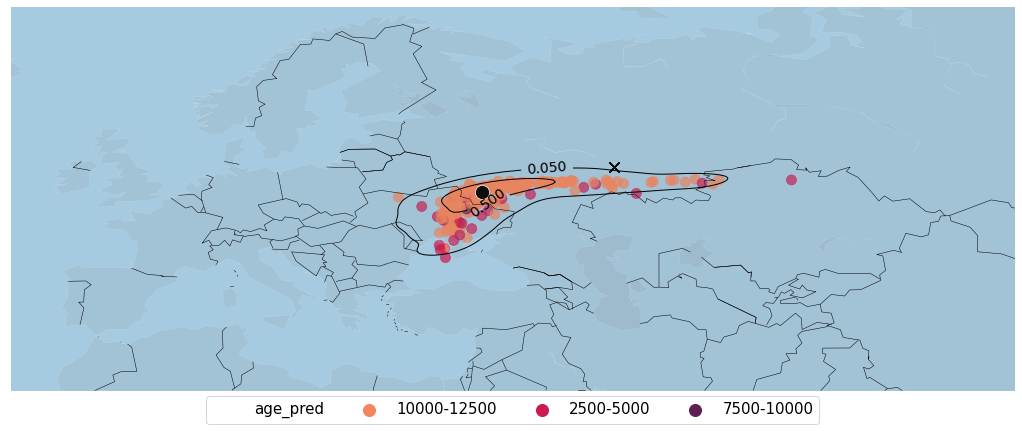

In [38]:
# Which individual to plot
individual = test_labels.query('id == "Sidelkino"')
individual_median = id_median_loc.query('id == "Sidelkino"')

# Gets contours 
xi, yi, zi, levels, origin = get_contour(individual)

# Plotting
plt.figure(figsize=(18, 14))
m=Basemap(projection='cyl', llcrnrlon=-15, llcrnrlat=30,urcrnrlon=95,urcrnrlat=72)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.1, lake_color='grey')
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcountries()

sns.scatterplot(data=individual, x='long_pred', y='lat_pred', hue='age_pred', s = 100, edgecolor=None, alpha=0.7, palette='rocket_r')#, palette=cmap)

sns.scatterplot(data=individual, x='long', y='lat', s = 100, color='k', marker='x')

CS = plt.contour(xi, yi, zi,levels = levels,
              colors=('k',),
              linewidths=(1,),
              origin=origin)

sns.scatterplot(data=individual_median, x='long_pred', y='lat_pred', s=200, color='k',marker='o')

plt.clabel(CS, fmt='%.3f', colors='black', fontsize=14)
plt.legend(bbox_to_anchor=(0.5, -0.05), loc='center', borderaxespad=0., ncol=6, fontsize=15, markerscale=2)
#plt.savefig('sidelkino_no_pol.png', bbox_inches = "tight")
plt.show()

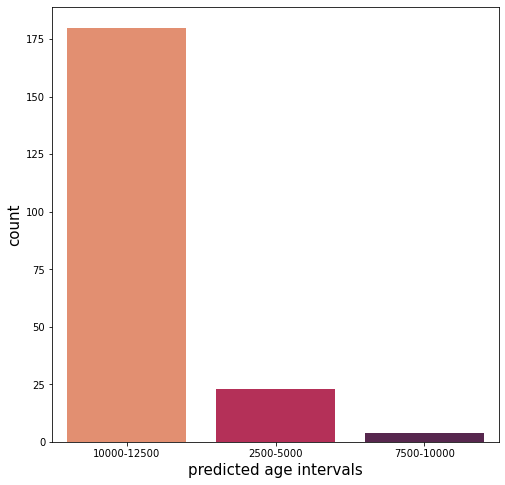

170008    11259
170044    11259
170307    11259
170468    11259
170730    11259
          ...  
199422    11259
199659    11259
199850    11259
199880    11259
199924    11259
Name: age, Length: 207, dtype: int64

In [39]:
plt.figure(figsize=(8, 8))
ax = sns.countplot(x = 'age_pred', data = individual, palette='rocket_r')
plt.xlabel('predicted age intervals', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.show()

individual.age

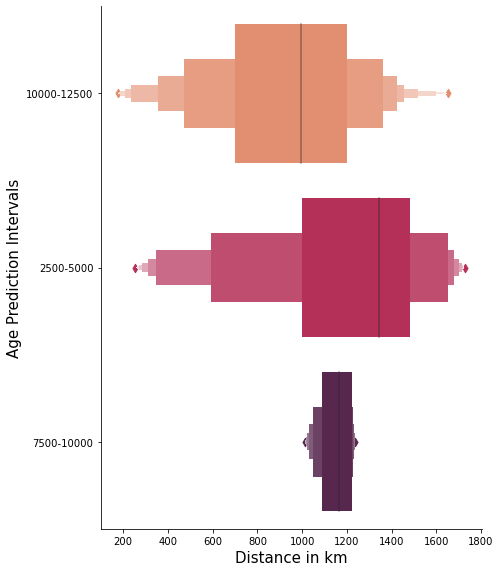

In [40]:
sns.catplot(y = 'age_pred', x='distance_km', data=individual, height=8, aspect=7/8, kind='boxen', palette='rocket_r')
plt.xlabel('Distance in km', fontsize=15)
plt.ylabel('Age Prediction Intervals', fontsize=15)
plt.show()

In [42]:
# All medians
medians = test_labels.groupby(['id', 'era', 'contry'], as_index=False).agg({'lat_pred':np.median, 'long_pred':np.median, 'lat':np.mean, 'long':np.mean, 'distance_km':np.median})

In [43]:
# Individual median
#medians = medians.query('contry == "Spain"')

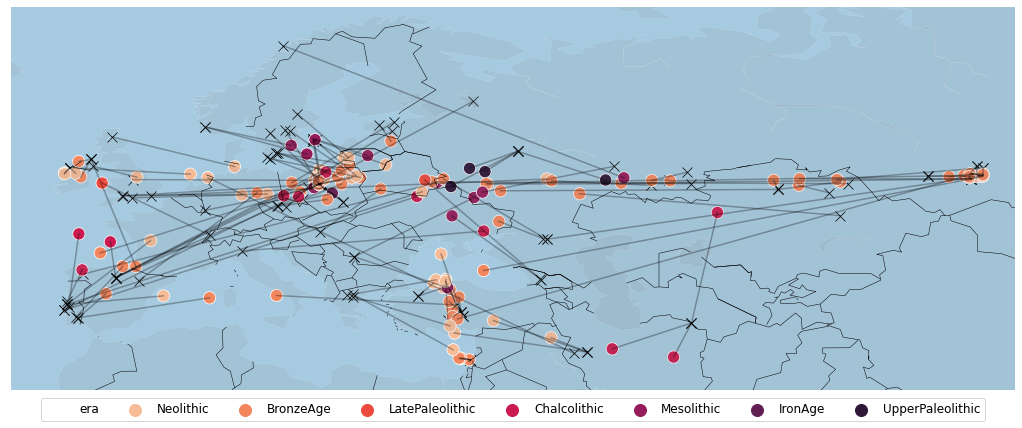

In [44]:
# Plotting
plt.figure(figsize=(18, 14))
m=Basemap(projection='cyl', llcrnrlon=-15, llcrnrlat=30,urcrnrlon=95,urcrnrlat=72)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.1, lake_color='grey')
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcountries()

sns.scatterplot(data=medians, x='long', y='lat', color='black', marker='x', s=100)

sns.scatterplot(data=medians, x='long_pred', y='lat_pred', hue='era', s = 150, palette='rocket_r')

m.plot(np.array([medians['long_pred'], medians['long']]),
        np.array([medians['lat_pred'], medians['lat']]), c = 'black', alpha=0.3)

plt.legend(bbox_to_anchor=(0.5, -0.05), loc='center', borderaxespad=0., ncol=8, fontsize=12, markerscale=2)

plt.show()